# Klasifikacija vina na osnovu fizičko-hemijskih svojstva

U ovom projektu klasifikujemo vina na osnovu njihovih fizičko-hemijskih osobina korišćenjem različitih algoritama mašinskog učenja. Inspirisani radom na klasifikaciji Vinho Verde vina, cilj nam je da kreiramo robustan model koji može predvideti stil vina na osnovu merljivih karakteristika kao što su kiselost, sadržaj alkohola i rezidualni šećer. 

Modeli koje ispitujemo su:
* Logistička regresija
* Naivni Bajesov klasifikator
* Metod potpornih vektora
* Nasumična šuma

Modele poredimo po težinskom f1-skoru i interpretabilnosti.

In [19]:
from ucimlrepo import fetch_ucirepo
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import RandomOverSampler

Koristimo isti skup podataka koji smo koristili za predikciju kvaliteta vina:

In [3]:
wine_quality = fetch_ucirepo(id=186)
df = wine_quality.data.original
df.head()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Na osnovu karakteristika vina ($X$) određujemo vrstu ($Y$). Podatke delimo na skupove za trening, validaciju i test, tako da im ostane isti odnos instanci kojese odnose na crno i na belo vino.

Podatke skaliramo na osnovu raspodele podataka u skupu za trening i validaciju.

In [20]:
X = df.iloc[:, :-2]  
y = df['color']

scaler = StandardScaler()

X_train_validation, X_test, y_train_validation, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

X_train_validation_scaled = scaler.fit_transform(X_train_validation)
X_test_scaled = scaler.transform(X_test)

X_train_scaled, X_val_scaled, y_train, y_val = model_selection.train_test_split(X_train_validation_scaled, y_train_validation, test_size=0.2, random_state=42, stratify=y_train_validation)
#print(X_train_validation.describe(), y_train_validation.describe())

Iz podataka možemo uočiti da bela i crna vina nisu jednako zastupljena, kao i distribucije različitih karakteristika vina u zavisnosti od njihove vrste:

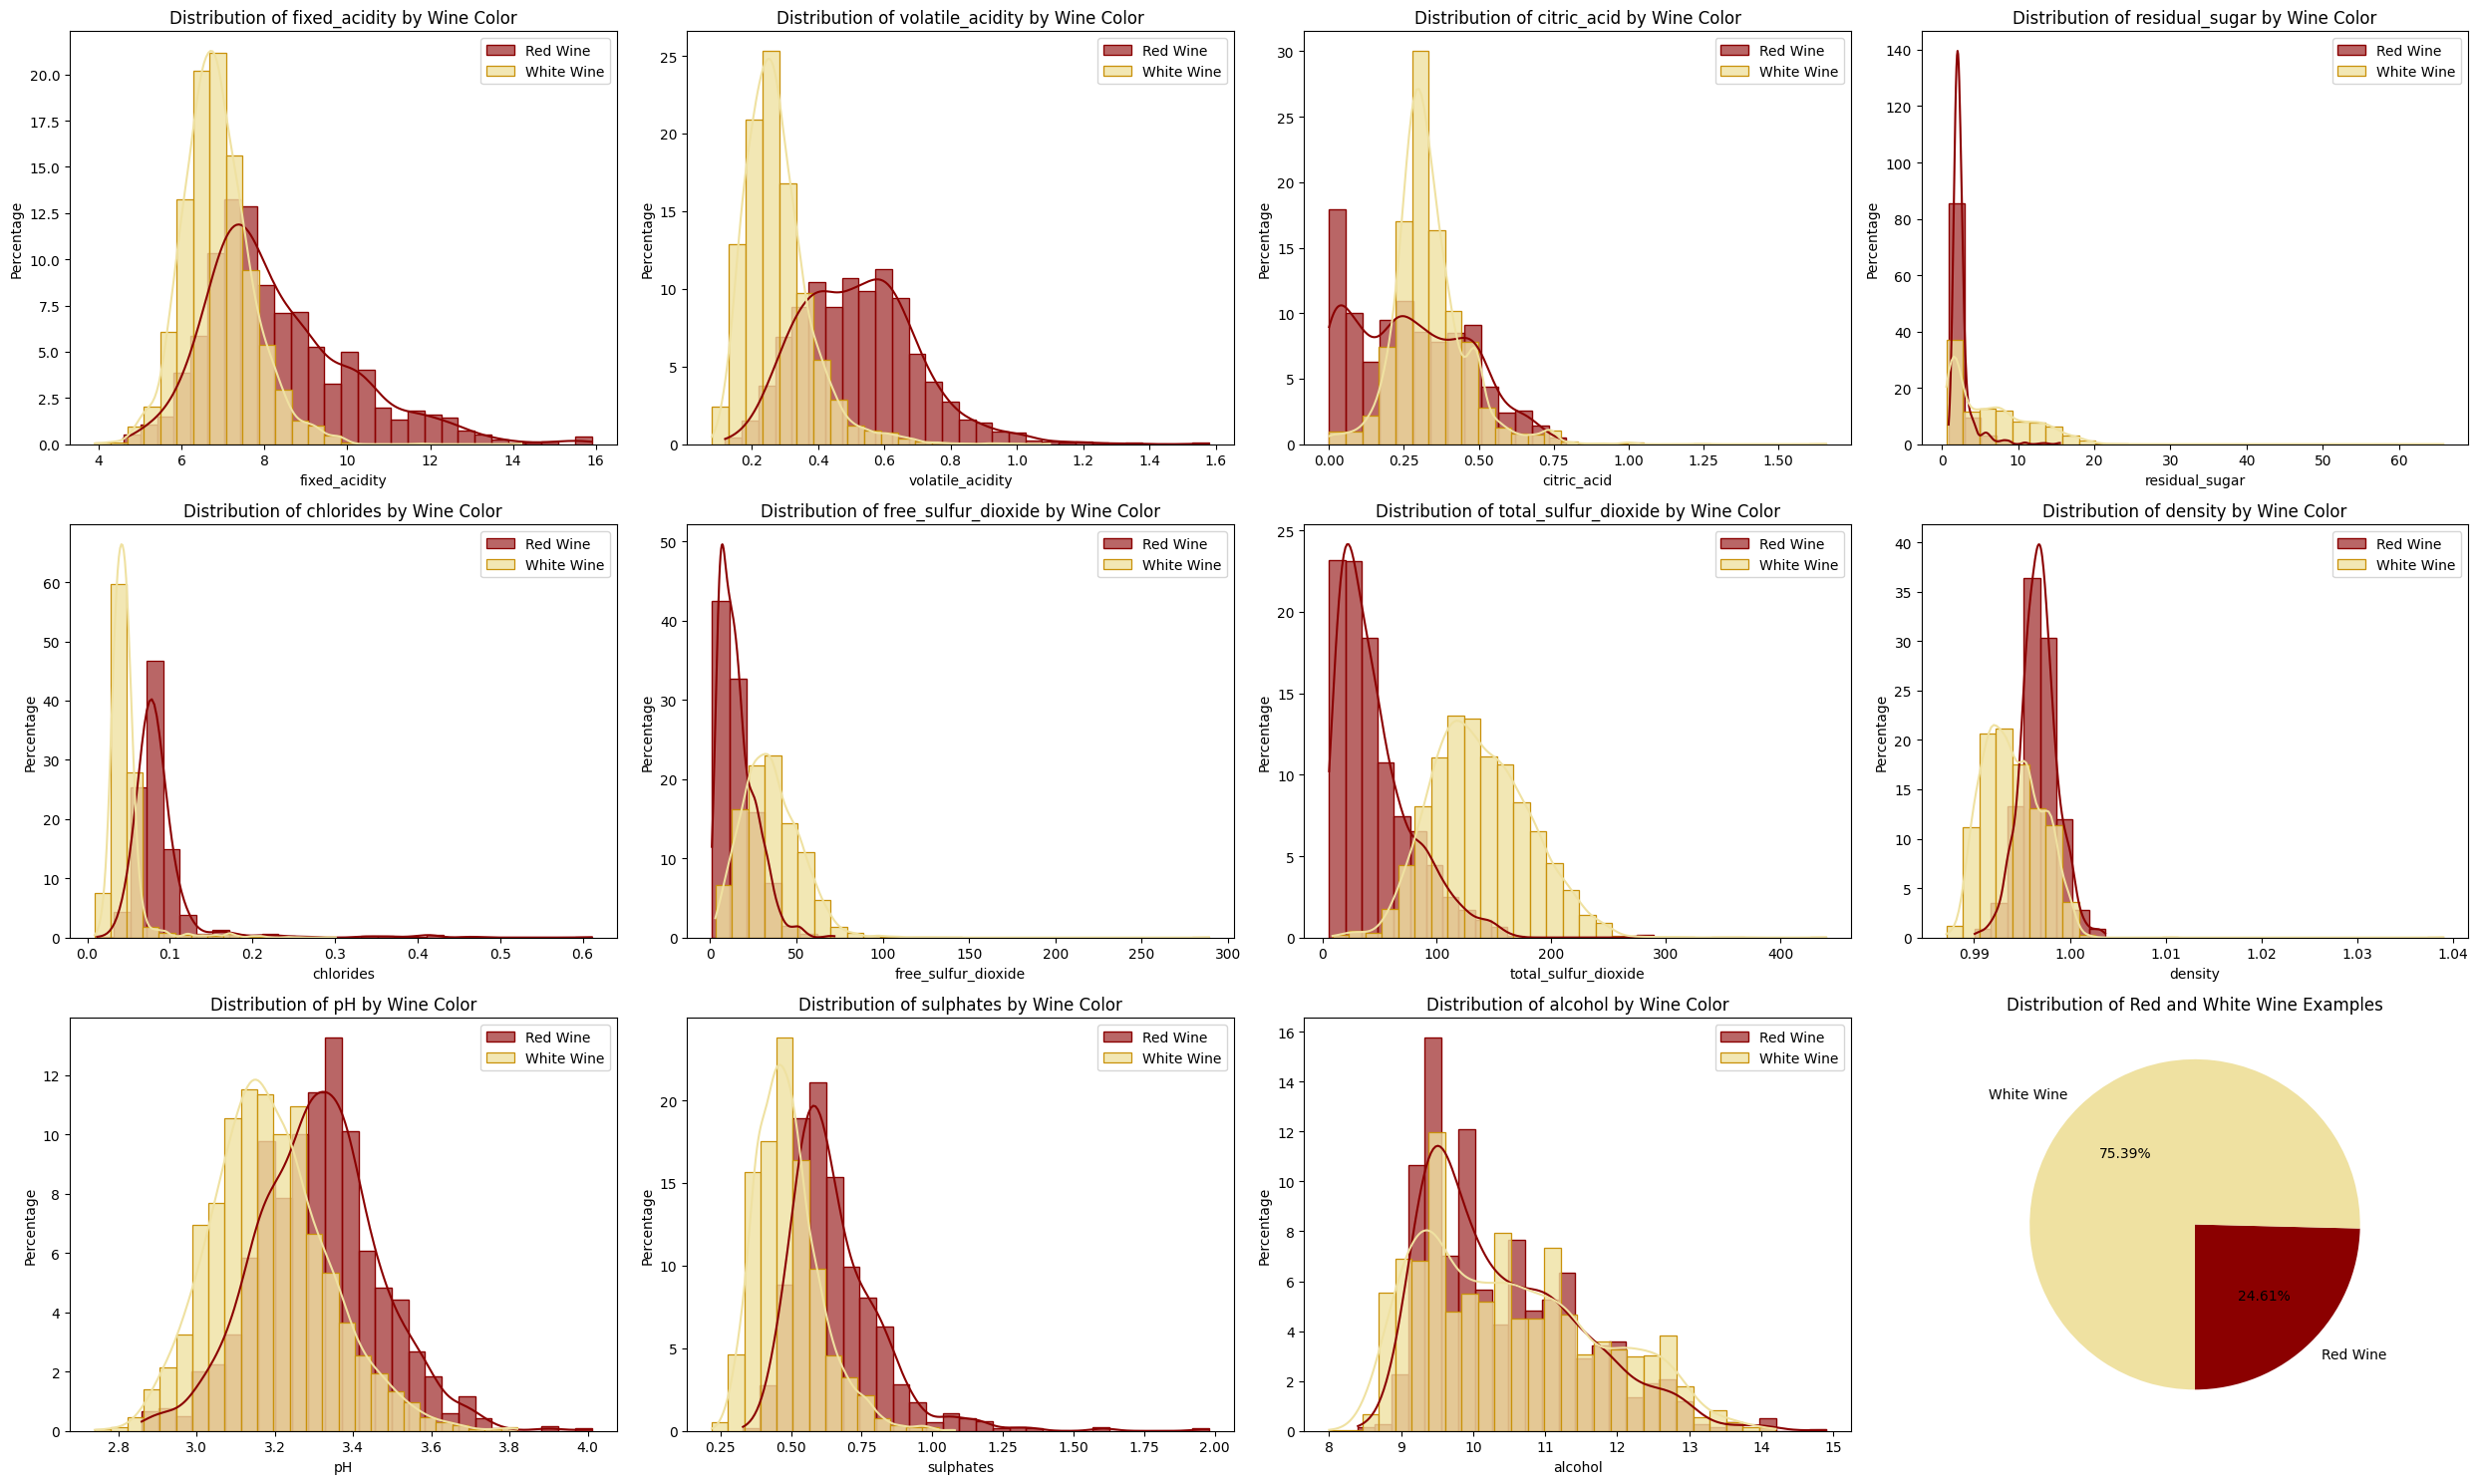

In [21]:
red_wine = X_train_validation[y_train_validation == 'red']
white_wine = X_train_validation[y_train_validation == 'white']

fig, axes = plt.subplots(3, 4, figsize=(25, 15))

axes = axes.flatten()

for i, column in enumerate(X_train_validation.columns):
    ax = axes[i]
    
    combined_min = min(red_wine[column].min(), white_wine[column].min())
    combined_max = max(red_wine[column].max(), white_wine[column].max())
    combined_range = combined_max - combined_min
    binwidth = combined_range / 30

    sb.histplot(red_wine[column], color='darkred', edgecolor='darkred', kde=True, label='Red Wine', alpha=0.6, stat='percent', binwidth=binwidth, ax=ax)
    sb.histplot(white_wine[column], color='#EFE1A1', edgecolor='#C9910A', kde=True, label='White Wine', alpha=0.8, stat='percent', binwidth=binwidth, ax=ax)
    
    ax.set_title(f'Distribution of {column} by Wine Color')
    ax.set_xlabel(column)
    ax.set_ylabel('Percentage')
    ax.legend()


ax_pie = axes[-1]

wine_counts = [len(red_wine), len(white_wine)]
wine_labels = ['Red Wine', 'White Wine']
wine_colors = ['darkred', '#EFE1A1']

ax_pie.pie(wine_counts, labels=wine_labels, colors=wine_colors, autopct='%.2f%%', startangle=-90)
ax_pie.set_title('Distribution of Red and White Wine Examples')

plt.tight_layout()
plt.show()

Vidimo da za pojedine karakteristike, kao što su gustina i slatkoća, veoma razlikuju u zavisnosti od vrste vina, što nam sugeriše da bi jednostavniji model kao što je logistička regresija mogao biti dobar za njihovu klasifikaciju.

Modele ćemo porediti po metrikama računatim na validacionom skupu. Kako je u pitanju klasifikacija nebalansiranih klasa, posebno obraćamo pažnju na težinsku sredinu $f_1$ skora.

In [7]:
def show_report(model_name, model, x_val, y_val):
    y_val_pred = model.predict(x_val)
    report = classification_report(y_val, y_val_pred, target_names=['Red Wine', 'White Wine'], digits=3)
    print(f"Validation Report for {model_name}:\n\n {report}")
    
    cm = confusion_matrix(y_val, y_val_pred)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Red Wine', 'White Wine'])

    cm_display.plot(cmap='GnBu')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()
    
def show_coeffs(model_name,model):
    coefficients = model.coef_[0]
    features = X.columns
    coeff_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients})
    coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)

    print(f"{model_name} Coefficients: \n\n{coeff_df}\n")

## Logisticka regresija

Prvi metod koji koristimo za klasifikaciju je logistička regresija, koja predviđa verovatnoću da primer pripada određenoj kategoriji. 

Kako su kategorije nebalansirane (više belih nego crnih vina), model bi mogao favorizovati većinsku klasu. Da bismo to izbegli, koristimo tehniku **nasumičnog preuzrokovanja**, nasumičnim ponavljanjem uzoraka manje reprezentovane klase kako bi se izjednačio broj primera obe klase. Time poboljšavamo sposobnost modela da prepozna i precizno klasifikuje primere iz manjinske klase.

Kako su karakteristike normalizovane, iz dobijenih koeficijenata vidimo pozitivnu korelaciju gustine i procenta alkohola sa "crvenosti" vina, kao i korelaciju slatkoće i količine sulfur-dioksida sa belim vinom, što smo i pretpostavil iz grafika raspodela karakteristika. Sa druge strane, pH vrednost ima najmanji apsolutni koeficijent, što je takođe očekivano zbog sličnosti u raspodelama.

Logistic Regression with ROS Coefficients: 

                 Feature  Coefficient
3         residual_sugar     2.896866
6   total_sulfur_dioxide     2.677972
0          fixed_acidity     0.459971
2            citric_acid     0.326607
8                     pH     0.054407
9              sulphates    -0.531071
5    free_sulfur_dioxide    -0.783354
1       volatile_acidity    -0.909940
4              chlorides    -0.911268
10               alcohol    -2.272455
7                density    -5.108033

Validation Report for Logistic Regression with ROS:

               precision    recall  f1-score   support

    Red Wine      0.979     0.983     0.981       240
  White Wine      0.995     0.993     0.994       735

    accuracy                          0.991       975
   macro avg      0.987     0.988     0.988       975
weighted avg      0.991     0.991     0.991       975



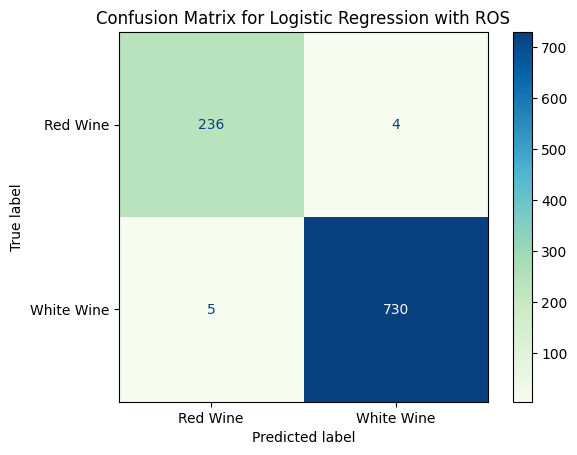

In [22]:
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_scaled, y_train)

logistic_model_ros = LogisticRegression(random_state=42)
logistic_model_ros.fit(X_train_resampled, y_train_resampled)

show_coeffs("Logistic Regression with ROS", logistic_model_ros)
show_report("Logistic Regression with ROS", logistic_model_ros, X_val_scaled, y_val)

## Naivni Bajesov klasifikator

**Gausov naivni Bajesov algoritam** je klasifikacioni algoritam koji pretpostavlja da su vrednosti svake karakteristike unutar svake klase distribuirane prema normalnoj (Gausovoj) distribuciji, i međusobno nezavisne.

Kako su parametri našeg modela fizičko-hemijske karakteristike, one imaju normalu distribuciju (što smo mogli videti na graficima), ali nisu nezavisne.

#### Metoda:

- **Normalna distribucija**: Za svaku klasu, model izračunava sredinu $\mu_k$ i varijansu $\sigma_k^2$ za svaku karakteristiku. Kada se dobije nova vrednost neke karakteristike, verovatnoća da ta vrednost pripada određenoj klasi računa se pomoću formule za normalnu distribuciju.

- **Izračunavanje verovatnoće**:
  
  Verovatnoća da data vrednost karakteristike $v$ pripada određenoj klasi $C_k$ računa se korišćenjem funkcije gustine verovatnoće za normalnu distribuciju, gde su $\mu_k$ i $\sigma_k^2$ sredina i varijansa te karakteristike unutar klase $C_k$:
  
  $$
  p(x = v \mid C_k) = \frac{1}{\sqrt{2\pi \sigma_k^2}} \, e^{-\frac{(v - \mu_k)^2}{2\sigma_k^2}}
  $$
  
  Ova formula omogućava izračunavanje verovatnoće da određena vrednost $v$ pripada klasi $C_k$, uz pretpostavku da su podaci u toj klasi normalno distribuirani.






Vidimo da ovaj model daje lošiji težinski prosek f1 skora, što se može objasniti pogrešnom pretpostavkom o nezavisnosti atributa.

Validation Report for GaussianNB:

               precision    recall  f1-score   support

    Red Wine      0.904     0.979     0.940       240
  White Wine      0.993     0.966     0.979       735

    accuracy                          0.969       975
   macro avg      0.948     0.973     0.960       975
weighted avg      0.971     0.969     0.970       975



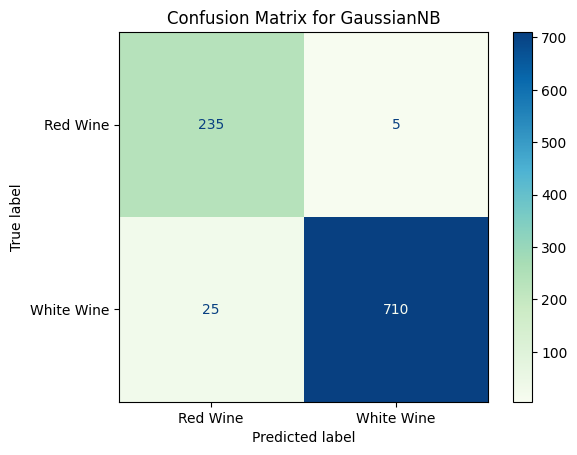

In [23]:
nb_model = GaussianNB()
nb_model.fit(X_train_resampled, y_train_resampled)

show_report("GaussianNB", nb_model, X_val_scaled, y_val)

## Metod potpornih vektora

Zbog vidnih razlika u raspodelama pojedinih karakteristika za belo i crno vino, možemo očekivati da će podaci biti približno linearno separabilni, zbog čeka je sledeća metoda koju testiramo metod potpornih vektora.

Iz rezultata vidimo da su koeficijenti ove metode u sličnom relativnom odnosu kao koeficijenti logističke regresije, što dodato ukazuje na dobru linearnu separabilnost podataka?

Validation Report for Support Vector Classifier:

               precision    recall  f1-score   support

    Red Wine      0.992     0.983     0.987       240
  White Wine      0.995     0.997     0.996       735

    accuracy                          0.994       975
   macro avg      0.993     0.990     0.992       975
weighted avg      0.994     0.994     0.994       975



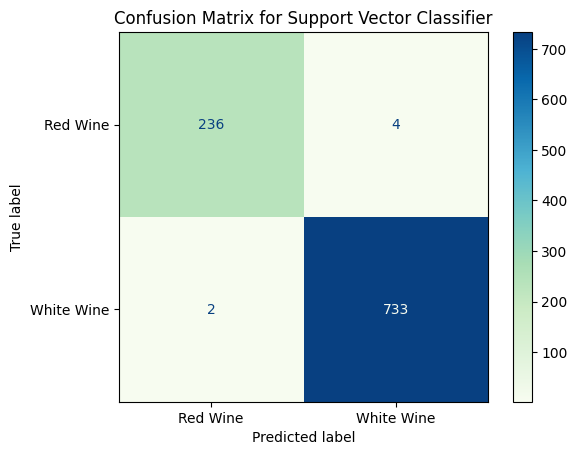

In [24]:
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_resampled, y_train_resampled)

show_report("Support Vector Classifier", svm_model, X_val_scaled, y_val)

In [17]:
print(svm_model.n_support_)

[83 79]


In [12]:
show_coeffs("SVM", svm_model)
show_coeffs("Logistic Regression", logistic_model_ros)

SVM Coefficients: 

                 Feature  Coefficient
3         residual_sugar     1.634235
6   total_sulfur_dioxide     1.183550
0          fixed_acidity     0.348808
2            citric_acid     0.198555
8                     pH     0.164849
9              sulphates    -0.094475
4              chlorides    -0.304818
1       volatile_acidity    -0.347739
5    free_sulfur_dioxide    -0.477465
10               alcohol    -1.288558
7                density    -2.839140

Logistic Regression Coefficients: 

                 Feature  Coefficient
3         residual_sugar     2.864427
6   total_sulfur_dioxide     2.702436
0          fixed_acidity     0.468190
2            citric_acid     0.320794
8                     pH     0.057998
9              sulphates    -0.537060
5    free_sulfur_dioxide    -0.797006
1       volatile_acidity    -0.900641
4              chlorides    -0.916166
10               alcohol    -2.291327
7                density    -5.051486



## Nasumična šuma

Sledeći model koji koristimo je nasumična šuma. Medijalna dubina stabla je 12. Iz rezultata vidimo da je za nasumična stabla količina hlora bila parametar od velikog značaja, dok je u prethodnim modelima imao koeficijent blizak nuli.

Ovaj model daje najveću težinsku sredinu f1 skora među testiranim, u iznosu od 0.995.

Prosečna dubina stabala: 12.0


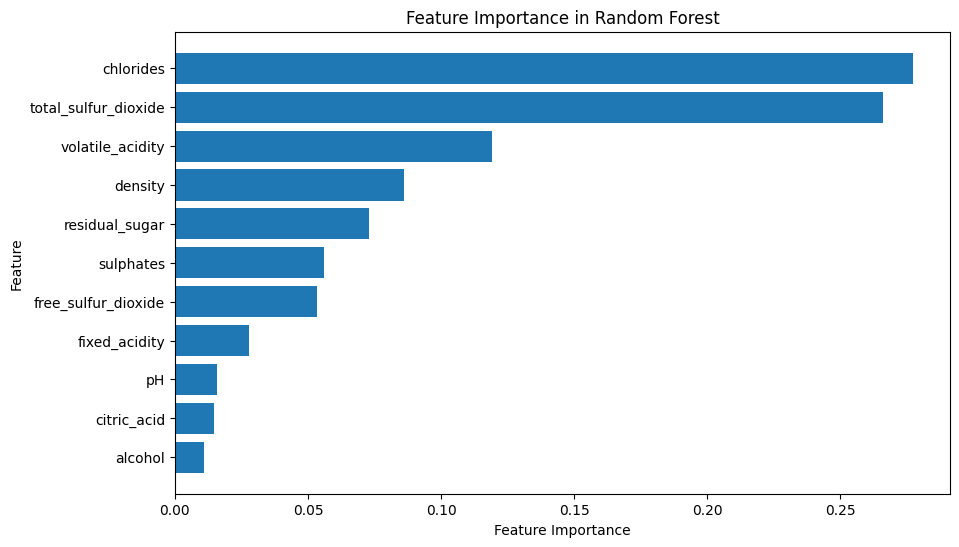

Validation Report for Random Forest:

               precision    recall  f1-score   support

    Red Wine      0.996     0.983     0.990       240
  White Wine      0.995     0.999     0.997       735

    accuracy                          0.995       975
   macro avg      0.995     0.991     0.993       975
weighted avg      0.995     0.995     0.995       975



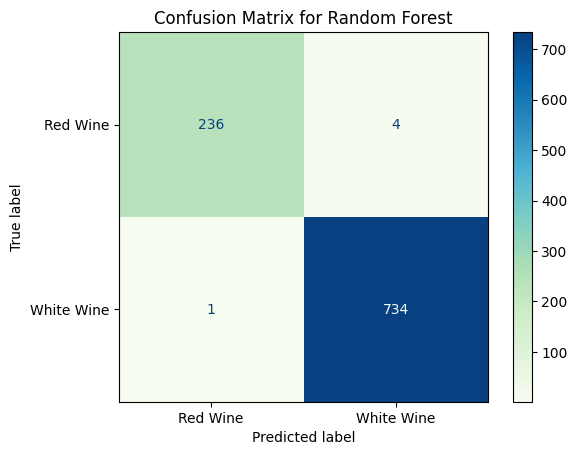

In [18]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
medain_depth =  np.median(tree_depths)
print(f"Prosečna dubina stabala: {medain_depth}")

feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  
plt.show()

show_report("Random Forest", rf_model, X_val_scaled, y_val)

# Zaključak

Od testiranih modela najbolje rezultate na validacionom skupu daje nasumična šuma. Taj model biramo kao optimalan po težinskom f1-skoru, treniramo ga na objedinjenim skupovima za obučavanje i validaciju, i dajemo konačnu evaluaciju na osnovu skupa za testiranje.

Iako malo manji, sličan skor daje logistička regresija uz nezanemarivu prednost jednostavnosti i interpretabilnosti.

Prosečna dubina stabala: 13.0


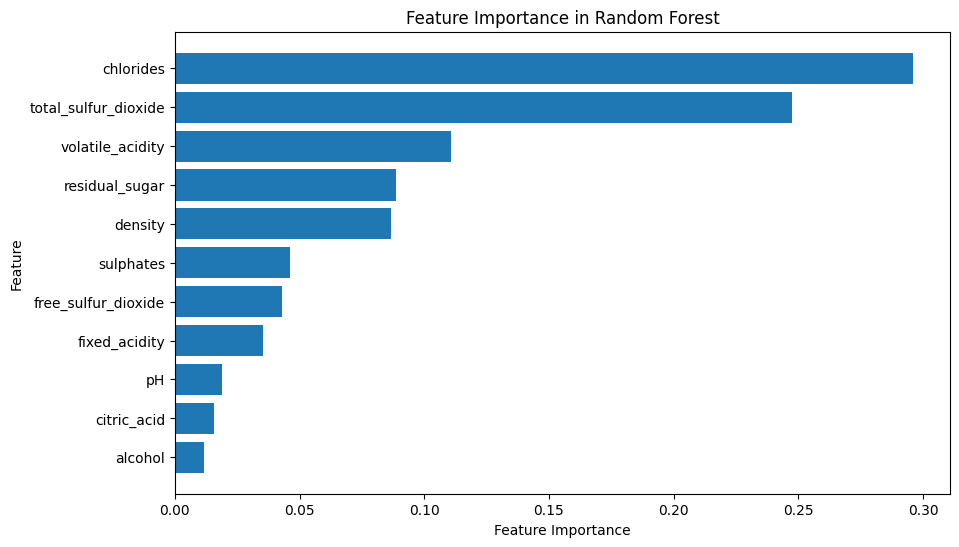

Validation Report for Random Forest:

               precision    recall  f1-score   support

    Red Wine      0.988     0.990     0.989       400
  White Wine      0.997     0.996     0.996      1225

    accuracy                          0.994      1625
   macro avg      0.992     0.993     0.993      1625
weighted avg      0.994     0.994     0.994      1625



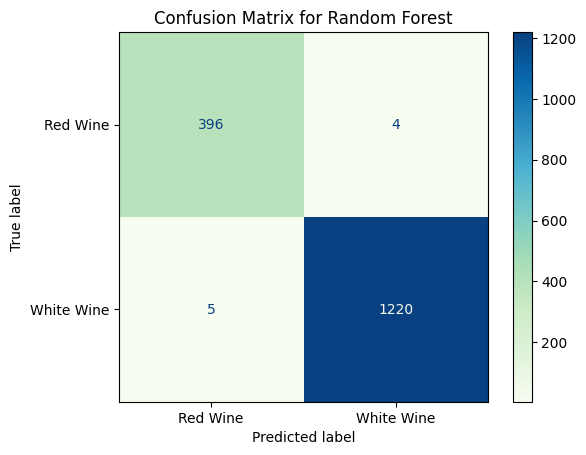

In [26]:
X_train_val_resampled, y_train_val_resampled = ros.fit_resample(X_train_validation_scaled, y_train_validation)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_val_resampled, y_train_val_resampled)

tree_depths = [estimator.tree_.max_depth for estimator in rf_model.estimators_]
medain_depth =  np.median(tree_depths)
print(f"Prosečna dubina stabala: {medain_depth}")

feature_importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest')
plt.gca().invert_yaxis()  
plt.show()

show_report("Random Forest", rf_model, X_test_scaled, y_test)